<h3>0.0 CARGA DE BIBLIOTECAS, VARIABLES, CLASES Y MÉTODOS IMPORTANTES</h3>

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout, LSTM, Dense, Embedding
import pickle
import json
import os
import sys

num_lilith = '05'
archivo_json_original    = '../../Chessia_Data_Convert/Target Data/original/Datos-V2.json'
archivo_json_nuevosDatos = '../../Chessia_Data_Convert/Target Data/lilith03To05/Datos-V2.json'
tokens_previos = 'origen03/tokens03.pkl'
tokens_lilith = "tokens"+num_lilith+".pkl"

class Partida:
    def __init__(self):
        self.movimientos = []
        self.resultado = None

# Función para cargar partidas en lotes
def cargar_partidas_por_rango(archivo_json, inicio=0, fin=None):
    total_movimientos = []
    total_resultados = []
    with open(archivo_json, 'r') as file:
        # Carga el contenido completo como una lista de objetos JSON
        lista_json = json.load(file)
        
        if fin is None or fin > len(lista_json):
            fin = len(lista_json)

        # Itera sobre cada objeto JSON en la lista
        for i in range(inicio, fin):
            total_movimientos.append(lista_json[i]['partida']['movimientos'])
            total_resultados.append(lista_json[i]['partida']['resultado'])
            
    return total_movimientos, total_resultados

def ver_tablas(history):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    epocas = range(1, len(history.history['loss']) + 1)

    # Graficar la precisión
    axs[0].plot(epocas, history.history['accuracy'], 'r', label='Precisión en entrenamiento')
    axs[0].plot(epocas, history.history['val_accuracy'], 'b', label='Precisión en validación')
    axs[0].set_title('Precisión en entrenamiento y validación')
    axs[0].set_xlabel('Épocas')
    axs[0].set_ylabel('Precisión')
    axs[0].legend()

    # Graficar la pérdida
    axs[1].plot(epocas, history.history['loss'], 'r', label='Pérdida en entrenamiento')
    axs[1].plot(epocas, history.history['val_loss'], 'b', label='Pérdida en validación')
    axs[1].set_title('Pérdida en entrenamiento y validación')
    axs[1].set_xlabel('Épocas')
    axs[1].set_ylabel('Pérdida')
    axs[1].legend()

    plt.tight_layout()  # Ajustar el diseño para evitar superposiciones
    plt.show()


class PlotMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        try:
            if self.model.history:
                ver_tablas(self.model.history)

        except Exception as e:
            print("Error al mostrar la gráfica:", e)

<h3>3.0 PROCESADO DE DATOS DE MEJORA - USA ProcesadorPGN_V2 Y SEGUNDA TANDA DE INFO 03 TO 05</h3>

In [2]:
# Convertir el generador en una lista y extraer la primera tupla
recogido = cargar_partidas_por_rango(archivo_json_nuevosDatos)
movimientos = recogido[0]
resultados = recogido[1]
# Crear y ajustar el tokenizador
tokenizer = Tokenizer()

with open(tokens_previos, "rb") as f:
    tokenizer = pickle.load(f)

tokenizer.fit_on_texts(movimientos)

#Borramos los antiguos tokens si los hubiese
if os.path.exists(tokens_lilith):
    os.remove(tokens_lilith)

# Guardar el objeto Tokenizer en un archivo usando pickle
with open(tokens_lilith, "wb") as f:
    pickle.dump(tokenizer, f)

# Convertir todas las jugadas a secuencias de números enteros y luego a tensores válidos
movimientos_tokenized = tokenizer.texts_to_sequences(movimientos)
movimientos_tokenized = pad_sequences(movimientos_tokenized, maxlen=500, padding="pre")

resultados_tokenized = tf.one_hot([int(resultado) for resultado in resultados], depth=3)  # 3 clases: empate, victoria blanca, victoria negra

tensor_mov_entrena = tf.constant(movimientos_tokenized[:int(len(movimientos_tokenized) * 0.7) ])
tensor_res_entrena = tf.constant(resultados_tokenized [:int(len(resultados_tokenized)  * 0.7) ])
tensor_mov_prueba =  tf.constant(movimientos_tokenized[ int(len(movimientos_tokenized) * 0.7):])
tensor_res_prueba =  tf.constant(resultados_tokenized [ int(len(resultados_tokenized)  * 0.7):])

<h3>3.1 LILITH - DEFINICIÓN, ENTRENAMIENTO Y GRÁFICAS DE DATOS CON POCOS VALORES</h3>

<h4>&ensp;&ensp;3.1.1 CREACIÓN DEL MODELO</h4>

In [3]:
modelo = tf.keras.Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=256),
    LSTM(units=512, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
    LSTM(units=256, dropout=0.3, recurrent_dropout=0.3),
    Dense(units=256, activation='relu'),
    Dense(units=3, activation='softmax')
])

# Compilar el modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
modelo.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

<h4>&ensp;&ensp;3.1.2 ENTRENAMIENTO</h4>

In [4]:
history = None

try:
    # Definir callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    checkpoint = ModelCheckpoint(filepath='modelo_checkpoint.keras', save_best_only=True)
    plot_metrics = PlotMetricsCallback()

    try:
        modelo = tf.keras.models.load_model('modelo_checkpoint.keras')
        print("Checkpoint cargado. Continuando entrenamiento desde el último punto guardado...\n\n")
    except:
        print("No se encontró un checkpoint existente. Iniciando un nuevo entrenamiento...\n\n")

    # Entrenar el modelo con los callbacks
    history = modelo.fit(
        tensor_mov_entrena,
        tensor_res_entrena,
        epochs=15,
        initial_epoch=10,  # Especificar la primera época a ejecutar
        batch_size=256,
        validation_data=(tensor_mov_prueba, tensor_res_prueba),
        callbacks=[early_stopping, checkpoint]
    )

    # Guardar el modelo final
    modelo.save("lilith"+num_lilith+".keras")

    # Evaluar el modelo en los datos de prueba
    loss, accuracy = modelo.evaluate(tensor_mov_prueba, tensor_res_prueba)
    print("\n\nLoss en los datos de prueba:", loss)
    print("Precisión en los datos de prueba:", accuracy)

except:
    if history is not None:
        ver_tablas(history)
    else:
        exc_type, exc_value, exc_traceback = sys.exc_info()
        print(f"Error: {exc_type.__name__}: {exc_value}")

Checkpoint cargado. Continuando entrenamiento desde el último punto guardado...


Epoch 11/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 2993s 11s/step - accuracy: 0.8174 - loss: 0.4595 - val_accuracy: 0.7786 - val_loss: 0.5450
Epoch 12/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 3090s 11s/step - accuracy: 0.8142 - loss: 0.4709 - val_accuracy: 0.7836 - val_loss: 0.5346
Epoch 13/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 2958s 11s/step - accuracy: 0.8286 - loss: 0.4285 - val_accuracy: 0.7858 - val_loss: 0.5322
Epoch 14/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 3226s 12s/step - accuracy: 0.8378 - loss: 0.4141 - val_accuracy: 0.7896 - val_loss: 0.5299
Epoch 15/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 2473s 9s/step - accuracy: 0.8431 - loss: 0.3972 - val_accuracy: 0.7926 - val_loss: 0.5336
938/938 ━━━━━━━━━━━━━━━━━━━━ 533s 568ms/step - accuracy: 0.7914 - loss: 0.5284


Loss en los datos de prueba: 0.529927670955658
Precisión en los datos de prueba: 0.7896000146865845


<h4>&ensp;&ensp;3.1.3 ESTADÍSTICAS Y GRÁFICAS</h4>

AttributeError: 'NoneType' object has no attribute 'history'

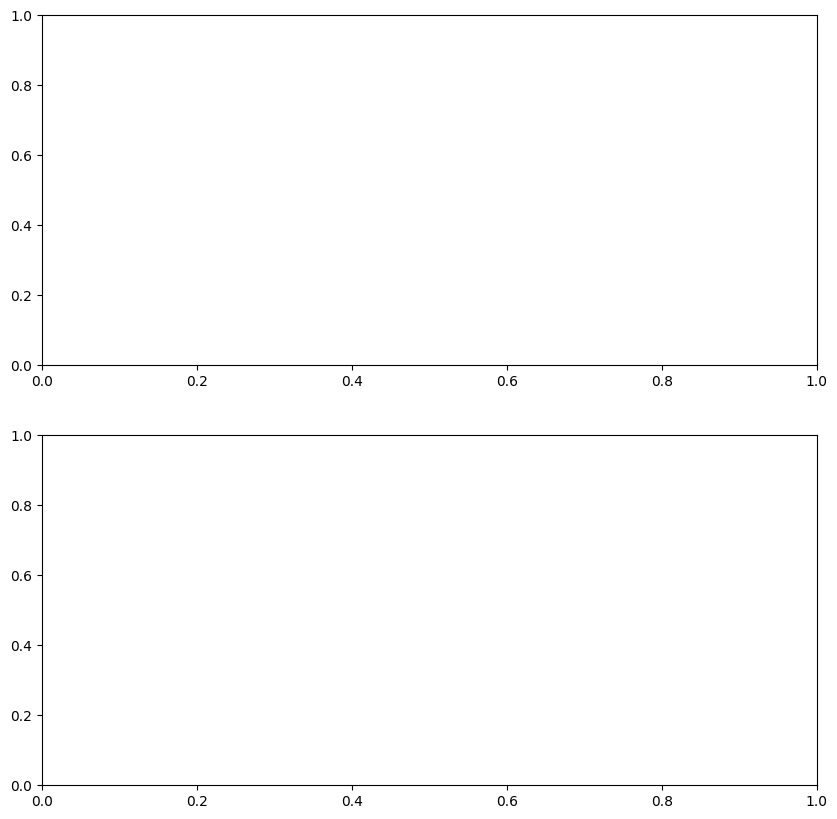

In [7]:
ver_tablas(history)

<h3>3.2 PRUEBA DE PREDICCIÓN LILITH</h3>

<h4>&ensp;&ensp;3.2.1 RECOGIDA DE DATOS Y TOKENS</h4>

In [20]:
movimientos, resultados = cargar_partidas_por_rango(archivo_json_original, inicio=100000)

# Creación del tokenizer
nuevo_tokenizer = Tokenizer()

# Cargar el objeto Tokenizer desde el archivo
with open(tokens_previos, "rb") as f:
    nuevo_tokenizer = pickle.load(f)

# nuevo_tokenizer.fit_on_texts(movimientos)
tensor_mov_pred = tf.constant(pad_sequences(nuevo_tokenizer.texts_to_sequences(movimientos), maxlen=500, padding="pre"))

<h4>&ensp;&ensp;3.2.2 PREDICCIÓN Y MUESTRA DE DATOS</h4>

In [15]:
np.set_printoptions(suppress=True, precision=4)

# lilith = tf.keras.models.load_model("lilith"+num_lilith+".keras")
lilith = tf.keras.models.load_model("origen03/lilith03.keras")
res_pred = lilith.predict(tensor_mov_pred)
aciertos = sumaAciertos = 0

for i in range(len(res_pred)):
    if int(resultados[i]) != int(np.argmax(res_pred[i])): char = '❌'
    else: 
        char = '✅'
        aciertos += 1
        sumaAciertos += res_pred[i][np.argmax(res_pred[i])]

    print(f"Predicción: {str(res_pred[i]):>22} -- Dice: {np.argmax(res_pred[i])} -- Real: {resultados[i]}  {char}  --- Aciertos: {aciertos:>5}/{i+1:<5} - {int(aciertos/(i+1)*100):>3}%")


105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 203ms/step
Predicción: [0.8646 0.0488 0.0867] -- Dice: 0 -- Real: 0  ✅  --- Aciertos:     1/1     - 100%
Predicción: [0.2814 0.7137 0.0049] -- Dice: 1 -- Real: 1  ✅  --- Aciertos:     2/2     - 100%
Predicción: [0.1396 0.7563 0.1041] -- Dice: 1 -- Real: 1  ✅  --- Aciertos:     3/3     - 100%
Predicción: [0.0507 0.9233 0.0259] -- Dice: 1 -- Real: 1  ✅  --- Aciertos:     4/4     - 100%
Predicción: [0.0804 0.7153 0.2044] -- Dice: 1 -- Real: 1  ✅  --- Aciertos:     5/5     - 100%
Predicción: [0.0098 0.9882 0.002 ] -- Dice: 1 -- Real: 1  ✅  --- Aciertos:     6/6     - 100%
Predicción: [0.0789 0.0405 0.8805] -- Dice: 2 -- Real: 1  ❌  --- Aciertos:     6/7     -  85%
Predicción: [0.6303 0.1762 0.1935] -- Dice: 0 -- Real: 2  ❌  --- Aciertos:     6/8     -  75%
Predicción: [0.1432 0.7991 0.0578] -- Dice: 1 -- Real: 0  ❌  --- Aciertos:     6/9     -  66%
Predicción: [0.1033 0.0833 0.8135] -- Dice: 2 -- Real: 0  ❌  --- Aciertos:     6/10    -  60%
Predicción: [0.7

In [17]:
print(f"{sumaAciertos/len(res_pred)}")

0.6591934644464237
